In [1]:
%matplotlib inline

from ROOT import TFile,vector
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import os

from PlottingScripts import CV, Spline, Tune1, distVar, distplot_wratio, distplot_wratio_dvar, StackedHisto, SimpleHisto, mcplot,dist2d_statsonly, Cov,DrawMatrix, datadataplot_wratio,  datadataplot_wratio_dvar
from DetSysScripts import FullCov

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

Welcome to JupyROOT 6.18/04


In [2]:
datafolder = '../../data'
dumpfolder = '../PlotDumps'

RSE  = ['run','subrun','event']

This notebook allows for rapid and easy production of data/data comparison plots using a modified version of the usual data/mc plotting script. It should be familiar to those who have used DL_1m1pSelectionPrime

In [3]:
#NUMU_RUN1_POT = 4.71579e+20 #in full sample
NUMU_RUN1_POT = 4.71579e+20-1.76704330551e+20  # not in training sample
#NUMU_LOWE_RUN1_POT = 1.63103516179e+21 # in full sample
NUMU_LOWE_RUN1_POT = 1.63103516179e+21-6.63688818656e+20 # not in training sample
NUE_RUN1_POT  = 9.80259e+22
RUN1_POT = 4.403e+19
EXTRUN1_POT = (22474918.0) / float ( 9776965.0) * RUN1_POT# * RUN1_NUMU_LOWE_TS
DIRT_RUN1_POT = 2.61947e+20

NUMU_RUN2_POT = 4.08963968669e+20
NUE_RUN2_POT = 9.2085012316e+22

#NUMU_RUN3_POT = 8.98773223801e+20 # in full sample
NUMU_RUN3_POT = 8.98773223801e+20-3.88480441949e+20# not in training
NUMU_LOWE_RUN3_POT = 1.51234621011e+21  # in full sample
#NUMU_LOWE_RUN3_POT = 1.1292236220503151e+21  # not in training
NUE_RUN3_POT = 4.70704675581e+22
RUN3_POT = 8.786e+18 # no beam quality  cut
EXTRUN3_POT = (39566274.0) / float (2263559) * RUN3_POT# * 0.6954257246376812

FD_SET1_RUN1_POT = 2.01093692636e+20
FD_SET1_RUN3b_POT = 2.92776909794e+20

FD_SET2_RUN1_POT = 3.617e+20
FD_SET2_RUN3b_POT = 3.841e+20

FD_SET3_RUN1_POT = 3.840e+20
FD_SET3_RUN3b_POT = 3.72E+20

FD_SET4_RUN1_POT = 3.9259599318e+20
FD_SET4_RUN3b_POT = 3.92745929386e+20

FD_SET5_RUN1_POT =  7.0219630122e+20

RUN1_FILTER_POT = 1.558e+20 + 1.129e+17 + 1.869e+19   # C1
RUN2_FILTER_POT = (1.63e+20 + 2.964e+19 + 1.239e+19) + (5.923e+19) # D2 + E1
RUN3_FILTER_POT = (1.701e+20 + 2.97e+19 + 1.524e+17) + (4.3e+19)    # G1 + F1
print(RUN1_FILTER_POT+RUN2_FILTER_POT+RUN3_FILTER_POT)

POT_SCALE_FACTOR = RUN2_FILTER_POT
print(POT_SCALE_FACTOR)

NUMU_RUN1_SCALE = POT_SCALE_FACTOR / float(NUMU_RUN1_POT)
NUMU_LOWE_RUN1_SCALE = POT_SCALE_FACTOR / float(NUMU_LOWE_RUN1_POT)
NUMU_RUN2_SCALE = POT_SCALE_FACTOR / float(NUMU_RUN2_POT)
NUMU_RUN3_SCALE = POT_SCALE_FACTOR / float(NUMU_RUN3_POT)
NUMU_LOWE_RUN3_SCALE = POT_SCALE_FACTOR / float(NUMU_LOWE_RUN3_POT)
NUE_RUN1_SCALE = POT_SCALE_FACTOR / float(NUE_RUN1_POT)
NUE_RUN2_SCALE = POT_SCALE_FACTOR / float(NUE_RUN2_POT)
NUE_RUN3_SCALE = POT_SCALE_FACTOR / float(NUE_RUN3_POT)
EXT_RUN1_SCALE = POT_SCALE_FACTOR / float(EXTRUN1_POT)
EXT_RUN3_SCALE = POT_SCALE_FACTOR / float(EXTRUN3_POT)
DIRT_RUN1_SCALE = POT_SCALE_FACTOR / float(DIRT_RUN1_POT)

RUN1_SCALE = POT_SCALE_FACTOR / float(RUN1_POT)
RUN3_SCALE = POT_SCALE_FACTOR / float(RUN3_POT)

RUN3_FT_SCALE = POT_SCALE_FACTOR / float(RUN3_FILTER_POT)
RUN2_FT_SCALE = POT_SCALE_FACTOR/float(RUN2_FILTER_POT)
RUN1_FT_SCALE = POT_SCALE_FACTOR/float(RUN1_FILTER_POT)

FD_SET1_RUN1_SCALE = POT_SCALE_FACTOR/float(FD_SET1_RUN1_POT)
FD_SET1_RUN3b_SCALE = POT_SCALE_FACTOR/float(FD_SET1_RUN3b_POT)
FD_SET2_RUN1_SCALE = POT_SCALE_FACTOR/float(FD_SET2_RUN1_POT)
FD_SET2_RUN3b_SCALE = POT_SCALE_FACTOR/float(FD_SET2_RUN3b_POT)
FD_SET3_RUN1_SCALE = POT_SCALE_FACTOR/float(FD_SET3_RUN1_POT)
FD_SET3_RUN3b_SCALE = POT_SCALE_FACTOR/float(FD_SET3_RUN3b_POT)
FD_SET4_RUN1_SCALE = POT_SCALE_FACTOR/float(FD_SET4_RUN1_POT)
FD_SET4_RUN3b_SCALE = POT_SCALE_FACTOR/float(FD_SET4_RUN3b_POT)
FD_SET5_RUN1_SCALE = POT_SCALE_FACTOR/float(FD_SET5_RUN1_POT)

print(RUN1_FILTER_POT,RUN2_FILTER_POT,RUN3_FILTER_POT)

6.818153e+20
2.6426e+20
1.746029e+20 2.6426e+20 2.429524e+20


In [4]:
#tag = 'Sept16_bdtseries4'
tag = 'Oct21_cmt'

df_numu_run1_presel = pd.read_parquet('%s/pickles/numu_run1_%s.parquet'%(datafolder,tag)).query('InTraining==0')
df_numu_run1_presel_lowe = pd.read_parquet('%s/pickles/numu_lowe_run1_%s.parquet'%(datafolder,tag))#.query('not InTraining==1')

df_numu_run2_presel= pd.read_parquet('%s/pickles/numu_run2_%s.parquet'%(datafolder,tag))

df_numu_run3_presel= pd.read_parquet('%s/pickles/numu_run3_%s.parquet'%(datafolder,tag)).query('InTraining==0')
df_numu_run3_presel_lowe= pd.read_parquet('%s/pickles/numu_lowe_run3_%s.parquet'%(datafolder,tag))#.query('InTraining==1')

df_nue_run1_presel = pd.read_parquet('%s/pickles/nue_run1_%s.parquet'%(datafolder,tag))#.query('not InTraining==1')
df_nue_run2_presel = pd.read_parquet('%s/pickles/nue_run2_%s.parquet'%(datafolder,tag))
df_nue_run3_presel = pd.read_parquet('%s/pickles/nue_run3_%s.parquet'%(datafolder,tag))#.query('not InTraining==1')

df_ext_run1_presel = pd.read_parquet('%s/pickles/ext_run1_%s.parquet'%(datafolder,tag))#.query('not InTraining==1')
df_ext_run3_presel = pd.read_parquet('%s/pickles/ext_run3_%s.parquet'%(datafolder,tag))#.query('not InTraining==1')

#df_data_run1_presel = pd.read_parquet('%s/pickles/data_run1_5e19_%s.parquet'%(datafolder,tag))
#df_data_run3_presel = pd.read_parquet('%s/pickles/data_run3_1e19_%s.parquet'%(datafolder,tag))

tag = 'Aug10_fullyloaded'

df_data_run1_filter_presel = pd.read_parquet('%s/pickles/data_run1_filter_%s.parquet'%(datafolder,tag))
df_data_run2_filter_presel = pd.read_parquet('%s/pickles/data_run2_filter_%s.parquet'%(datafolder,tag))
df_data_run3_filter_presel = pd.read_parquet('%s/pickles/data_run3_filter_%s.parquet'%(datafolder,tag))


df_fakedata_set1_run1_presel = pd.read_parquet('%s/pickles/fakedata_set1_run1_%s.parquet'%(datafolder,tag))
df_fakedata_set1_run3b_presel = pd.read_parquet('%s/pickles/fakedata_set1_run3b_%s.parquet'%(datafolder,tag))

df_fakedata_set2_run1_presel = pd.read_parquet('%s/pickles/fakedata_set2_run1_%s.parquet'%(datafolder,tag))
df_fakedata_set2_run3b_presel = pd.read_parquet('%s/pickles/fakedata_set2_run3b_%s.parquet'%(datafolder,tag))

df_fakedata_set3_run1_presel = pd.read_parquet('%s/pickles/fakedata_set3_run1_%s.parquet'%(datafolder,tag))
df_fakedata_set3_run3b_presel = pd.read_parquet('%s/pickles/fakedata_set3_run3b_%s.parquet'%(datafolder,tag))

tag = 'Sept8_fullyloaded_notraining'

df_fakedata_set4_run1_presel = pd.read_parquet('%s/pickles/fakedata_set4_run1_%s.parquet'%(datafolder,tag))
df_fakedata_set4_run3b_presel = pd.read_parquet('%s/pickles/fakedata_set4_run3b_%s.parquet'%(datafolder,tag))

df_fakedata_set5_run1_presel = pd.read_parquet('%s/pickles/fakedata_set5_run1_%s.parquet'%(datafolder,tag))


In [5]:
run1FilterTest = SimpleHisto(df_data_run1_filter_presel,RUN1_FT_SCALE,0,'','Run 1 Filtered')
run2FilterTest = SimpleHisto(df_data_run2_filter_presel,RUN2_FT_SCALE,0,'','Run 2 Filtered')
run3FilterTest = SimpleHisto(df_data_run3_filter_presel,RUN3_FT_SCALE,0,'','Run 3 Filtered')

run2NumuHist = SimpleHisto(df_numu_run2_presel,NUMU_RUN2_SCALE,1,'','Run 2 BNB Overlay')
run3NumuHist = SimpleHisto(df_numu_run3_presel,NUMU_RUN3_SCALE,1,'','Run 3 BNB Overlay')

In [6]:
# Make big list of variables with their accompanying ranges so we can just dump a buttload of plots
#varlistSel = {}
covfolder = 'CovMatrices_Aug10'
covtag = 'frac_covar_sel'

varListSel = {}

varListSel['Xreco'] = distVar('Xreco',(15,241.25),'Reco Vertex X',datafolder+'/'+covfolder+'/'+covtag+'__x_reco.txt')
varListSel['Yreco'] = distVar('Yreco',(-101.5,101.5),'Reco Vertex Y',datafolder+'/'+covfolder+'/'+covtag+'__y_reco.txt')
varListSel['Zreco'] = distVar('Zreco',(15,1021.8),'Reco Vertex Z',datafolder+'/'+covfolder+'/'+covtag+'__z_reco.txt')
varListSel['OpenAng'] = distVar('OpenAng',(.6,2.8),'Opening Angle (rads)',datafolder+'/'+covfolder+'/'+covtag+'__openang_reco.txt')
varListSel['Thetas'] = distVar('Thetas',(0,np.pi),r'Sum of Thetas ($\theta_{p} + \theta_{\mu}$) (rads)',datafolder+'/'+covfolder+'/'+covtag+'__sum_thetas_reco.txt')
varListSel['Phis'] = distVar('Phis',(1.5,4),r'Difference of Phis ($|\phi_{p} - \phi_{\mu}|$)  (rads)',datafolder+'/'+covfolder+'/'+covtag+'__sum_phis_reco.txt')
varListSel['ChargeNearTrunk'] = distVar('ChargeNearTrunk',(0,600),'ADC Charge within 5cm of Reco Vertex',datafolder+'/'+covfolder+'/'+covtag+'__charge_near_trunk_reco.txt')
varListSel['Enu_1m1p'] = distVar('Enu_1m1p',(200,1200),'Reconstructed Neutrino Energy (MeV)',datafolder+'/'+covfolder+'/'+covtag+'__nu_energy_reco.txt')
varListSel['PhiT_1m1p'] = distVar('PhiT_1m1p',(0,1),r'$\phi_T$',datafolder+'/'+covfolder+'/'+covtag+'__phiT_reco.txt')
varListSel['AlphaT_1m1p'] = distVar('AlphaT_1m1p',(0,np.pi),r'$\alpha_T$',datafolder+'/'+covfolder+'/'+covtag+'__alphaT_reco.txt')
varListSel['PT_1m1p'] = distVar('PT_1m1p',(0,320),r'$p_T$',datafolder+'/'+covfolder+'/'+covtag+'__pT_reco.txt')
varListSel['PTRat_1m1p'] = distVar('PTRat_1m1p',(0,.4),r'$p_T/|p|$',datafolder+'/'+covfolder+'/'+covtag+'__pT_ratio_reco.txt')
varListSel['BjXB_1m1p'] = distVar('BjXB_1m1p',(.2,1.8),'Bjorken X*',datafolder+'/'+covfolder+'/'+covtag+'__BjxB_reco.txt')
varListSel['BjYB_1m1p'] = distVar('BjYB_1m1p',(0.05,.75),'Bjorken Y*',datafolder+'/'+covfolder+'/'+covtag+'__BjyB_reco.txt')
varListSel['Q2_1m1p'] = distVar('Q2_1m1p',(0,6e5),r'$Q^2$',datafolder+'/'+covfolder+'/'+covtag+'__Q2_reco.txt')
varListSel['SphB_1m1p'] = distVar('SphB_1m1p',(0,1000),'QE Consistency*',datafolder+'/'+covfolder+'/'+covtag+'__sphB_reco.txt')
varListSel['Q0_1m1p'] = distVar('Q0_1m1p',(70,600),r'$Q_0$',datafolder+'/'+covfolder+'/'+covtag+'__Q0_reco.txt')
varListSel['Q3_1m1p'] = distVar('Q3_1m1p',(200,1000),r'$Q_3$',datafolder+'/'+covfolder+'/'+covtag+'__Q3_reco.txt')
varListSel['Lepton_PhiReco'] = distVar('Lepton_PhiReco',(-np.pi,np.pi),r'Muon $\phi$',datafolder+'/'+covfolder+'/'+covtag+'__lepton_phi_reco.txt')
varListSel['Lepton_ThetaReco'] = distVar('Lepton_ThetaReco',(.2,2.8),r'Muon $\theta$',datafolder+'/'+covfolder+'/'+covtag+'__lepton_theta_reco.txt')
varListSel['Lepton_TrackLength'] = distVar('Lepton_TrackLength',(20,200),'Muon Track Length (cm)',datafolder+'/'+covfolder+'/'+covtag+'__lepton_length_reco.txt')
varListSel['Muon_Edep'] = distVar('Muon_Edep',(50,600),'Reco Muon Energy (from range) (MeV)',datafolder+'/'+covfolder+'/'+covtag+'__lepton_KE_reco.txt')
varListSel['Proton_PhiReco'] = distVar('Proton_PhiReco',(-np.pi,np.pi),r'Proton $\phi$',datafolder+'/'+covfolder+'/'+covtag+'__proton_phi_reco.txt')
varListSel['Proton_ThetaReco'] = distVar('Proton_ThetaReco',(0,2),r'Proton $\theta$',datafolder+'/'+covfolder+'/'+covtag+'__proton_theta_reco.txt')
varListSel['Proton_TrackLength'] = distVar('Proton_TrackLength',(5,100),'Proton Track Length',datafolder+'/'+covfolder+'/'+covtag+'__proton_length_reco.txt')
varListSel['Proton_Edep'] = distVar('Proton_Edep',(50,500),'Reco Proton Energy (from range) (MeV)',datafolder+'/'+covfolder+'/'+covtag+'__proton_KE_reco.txt')
varListSel['Proton_CosTheta'] = distVar('Proton_CosTheta',(0,1),'Proton Cos Theta',datafolder+'/'+covfolder+'/'+covtag+'__proton_cos_theta_reco.txt')
varListSel['Lepton_CosTheta'] = distVar('Lepton_CosTheta',(-1,1),'Muon Cos Theta',datafolder+'/'+covfolder+'/'+covtag+'__lepton_cos_theta_reco.txt')
varListSel['MPID_eminus'] = distVar('MPID_eminus',(0,1),'Eminus MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_eminus_score.txt')
varListSel['MPID_muon'] = distVar('MPID_muon',(0,1),'Muon MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_muon_score.txt')
varListSel['MPID_proton'] = distVar('MPID_proton',(0,1),'Proton MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_proton_score.txt')
varListSel['MPID_gamma'] = distVar('MPID_gamma',(0,1),'Gamma MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_gamma_score.txt')
varListSel['MPID_pion'] = distVar('MPID_pion',(0,1),'Pion MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_pion_score.txt')

In [7]:
def poisson_errors(k, CL = 0.6827):
   # 1 Sig = 0.6827
   # 2 Sig = 0.9545
   # 3 Sig = 0.9973
   a = 1.0 - CL
   low, high = (stats.chi2.ppf(a/2, 2*k) / 2, stats.chi2.ppf(1-a/2, 2*k + 2) / 2)
   if k == 0:
       low = 0.0
   return k - low, high - k


def datadataplot_wratio_dvar(dvar,nbins,datahist1,datahist2,legpos=0,ymax=-1,normshift=1,fs=(16,11)):
    return datadataplot_wratio(dvar.myname,nbins,dvar.myrange,datahist1,datahist2,dvar.mylabel,legpos,ymax,normshift,fs)

def datadataplot_wratio(myvar,nbins,myrange,datahist1,datahist2,stxcoord,legpos=0,ymax=-1,normshift=1,fs=(16,11)):

    ndof = 0

    data1_vals,data1_wgt,data1_scale,_,data1_label = datahist1.GetHist(myvar)
    data2_vals,data2_wgt,data2_scale,_,data2_label = datahist2.GetHist(myvar)

    vals_data1_raw,binedges = np.histogram(data1_vals,nbins,range=myrange,weights=data1_wgt)
    vals_data1,_ = np.histogram(data1_vals,nbins,range=myrange,weights=np.multiply(data1_wgt,data1_scale))
    vals_data2_raw,_ = np.histogram(data2_vals,nbins,range=myrange,weights=data2_wgt)
    vals_data2,_ = np.histogram(data2_vals,nbins,range=myrange,weights=np.multiply(data2_wgt,data2_scale))
    bincenters = np.diff(binedges)/2 + binedges[:-1]
    
    #jarretbars
    a_obslo1 = []
    a_obshi1 = []
    a_obslo2 = []
    a_obshi2 = []
    for i in range(nbins):
        obslo,obshi = poisson_errors(vals_data1[i])
        a_obshi1.append(obshi)
        a_obslo1.append(obslo)
        obslo,obshi = poisson_errors(vals_data2[i])
        a_obshi2.append(obshi)
        a_obslo2.append(obslo)

    #m_cov is fractional, so we multiply it by MC
    m_cov = np.zeros((nbins,nbins))

    yerrsq_data = np.zeros(nbins)
    for i in range(nbins):
        if vals_data1[i] > 0 or vals_data2[i] > 0:
            ndof += 1
            m_cov[i][i] += vals_data1[i]*data1_scale[0] + vals_data2[i]*data2_scale[0]
        else:
            m_cov[i][i] += 999

    er_rat_linehi = np.zeros(nbins)
    er_rat_linelo = np.zeros(nbins)
    er_rat_dotshi = np.zeros(nbins)
    er_rat_dotslo = np.zeros(nbins)

    for i in range(nbins):
        if vals_data2[i] > 0:
            er_rat_linehi[i] = a_obshi2[i]/float(vals_data2[i])
            er_rat_linelo[i] = a_obslo2[i]/float(vals_data2[i])
            er_rat_dotshi[i] = a_obshi1[i]/float(vals_data2[i])
            er_rat_dotslo[i] = a_obslo1[i]/float(vals_data2[i])

    chisq = 0.0
    invcov = np.linalg.inv(m_cov)

    # calc chi2
    for i in range(nbins):
        for j in range(nbins):
            if vals_data2[i] > 0 or vals_data1[i] > 0:
                chisq += (vals_data1[i] - vals_data2[i]) * (vals_data1[j] - vals_data2[j]) * invcov[i][j]
    pval = 1 - stats.chi2.cdf(chisq, ndof)
    print(chisq/float(ndof),pval)

    fig,ax = plt.subplots(figsize=fs)
    fig.patch.set_alpha(1)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ymax = max((vals_data1+np.asarray(a_obshi1)).max(),(vals_data2+a_obshi2).max())*1.4

    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(0,2)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=25)
    ax0.set_ylabel('Events in 4.4e19 POT',fontsize=25)
    ax1.set_ylabel('Data/Data',fontsize=25)
    ax0.set_title('MCC9 %s/%s'%(data1_label,data2_label),fontsize=30)

    ax0.errorbar(bincenters,vals_data1,fmt='o',yerr=(a_obslo1,a_obshi1),color='orange',capsize=5,capthick=4,label=data1_label+' (%i)'%vals_data1.sum(),markersize=8,zorder=20,elinewidth=4)
    ax0.errorbar(bincenters,vals_data2,fmt='o',yerr=(a_obslo2,a_obshi2),color='blue',capsize=10,capthick=4,label=data2_label+' (%i)'%vals_data2.sum(),markersize=16,zorder=19,elinewidth=8)

    ax0.legend(loc='upper right',fontsize=20,frameon=False,ncol=3)

    errboxes_rat_tot = []
    for i in range(len(er_rat_dotshi)):
        rect0 = Rectangle((binedges[i],1-er_rat_linelo[i]),binedges[i+1]-binedges[i],er_rat_linehi[i]+er_rat_linelo[i])
        errboxes_rat_tot.append(rect0)

    pc_rat_tot = PatchCollection(errboxes_rat_tot, facecolor='blue', alpha=.3)
    ax1.add_collection(pc_rat_tot)
    ax1.errorbar(bincenters,np.true_divide(vals_data1,vals_data2),yerr=(er_rat_dotshi,er_rat_dotslo),fmt='o',color='orange',capsize=0,markersize=8,elinewidth=4)

    ax1.axhline(1,color='black',linestyle=':')
    ax0.annotate(r'$\sum$(%s)/$\sum$(%s) = %.2f'%(data1_label,data2_label,vals_data1.sum()/float(vals_data2.sum())),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))

    ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2_{CNP}/%i  (dof)$: %.3f'%(ndof,chisq/float(ndof)),xy=(.85,.75), xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="round4", fc="w",alpha=.9),zorder=30)

    plt.tight_layout()

    return fig,ax0,ax1,pval


In [8]:
bdtcuts = 'bkgBDT_univ < .4'
emptycut = 'Enu_1m1p > 0'
morecuts = 'Proton_CosTheta > 0'
bonuscuts = '(MPID_proton > .9 or Enu_1m1p > 400)'

s_cuts = morecuts + ' and ' + bonuscuts + ' and ' + bdtcuts

run1FilterTest.AddCut(s_cuts)
run2FilterTest.AddCut(s_cuts)
run3FilterTest.AddCut(s_cuts)

run2NumuHist.AddCut(s_cuts)
run3NumuHist.AddCut(s_cuts)

2.3376876419498362 0.0008268403715838701


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


Text(112.5, 0.5, 'Events in 1.7e20')

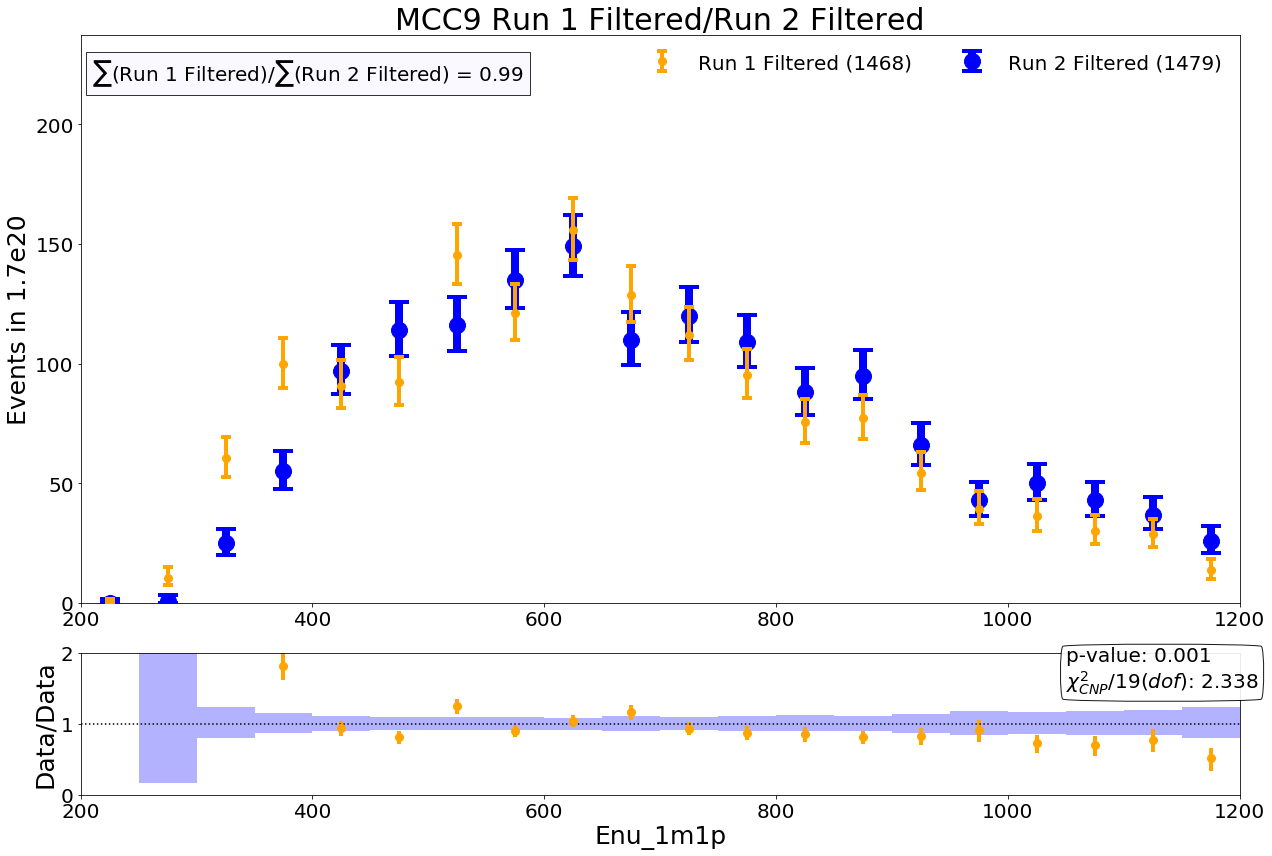

In [10]:
dumpbins=36

fig,ax0,ax1,_ = datadataplot_wratio('Enu_1m1p',20,(200,1200),run1FilterTest,run2FilterTest,'Enu_1m1p',fs=(18,12))
#fig,ax0,ax1,_ = datadataplot_wratio('Enu_1m1p',20,(200,1200),run2NumuHist,run3NumuHist,'Enu_1m1p',fs=(18,12))


ax0.set_ylabel('Events in 1.7e20')

In [60]:
# Dump plots for all listed variables (in varListSel) into some defined location (dumphole)

dumpbins = 14
dumphole = 'datadata_run3overrun2_postsel' # where are we dumping these?

dumphole = '%s/%s'%(dumpfolder,dumphole)
if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for x,dist in varListSel.items():
    fig,ax0,ax1,_ = datadataplot_wratio_dvar(dist,14,run3FilterTest,run2FilterTest,fs=(18,12))
    ax0.set_ylabel('Events in 2.64e19',fontsize=25)
    #plt.savefig(dumphole+'/'+dist.myname+'.png')
    plt.close(fig)

1.1199701490141702 0.3333308957387987
0.9306719855052231 0.5242093302539965
0.5975556650448254 0.8694128826976716
0.6703764462530365 0.8056069099361167
0.7796118152056563 0.6723171097201186


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


0.7104838597862019 0.766064439872797
1.1363482974562895 0.3189707601449532
1.5499864975525584 0.09153686789551718
1.0958686256832073 0.35517223761098815
0.7564687699470661 0.7178586321208309
0.6684262624466377 0.8074584239046836
1.016958049999728 0.4321775878268841
0.6121284543249838 0.833959787626002
0.9672621753225763 0.4811961209896318
0.8526444195602912 0.6113605149587715
1.2034260033542419 0.26437048951146735
0.7990094678722262 0.6713558046131924
0.5749632652839675 0.8867320098245077
0.5613759013499903 0.896528414664154
1.1635097319339776 0.2960378209209549
1.2005401079400309 0.2665780985706675
1.303250730040433 0.19582672306452598
0.7680062265310493 0.7053924374867244
0.576505580366092 0.8496302479070243
0.70261828279702 0.7740255960162536
0.9985237806773309 0.451251915010199
0.46208045815233184 0.953247991724135
1.144641388888585 0.31185118797340383
1.2607186839690503 0.2231864333937169
1.672676548275652 0.05380679592988513
1.2162169093226625 0.25473993047414023
0.95810835587359